In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Metal (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

print(f'Device: {device}')



Using Apple Metal (MPS)
Device: mps


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

num_workers = 0 if device.type == 'mps' else 2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100.0%


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
print(model)



CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



In [10]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc



In [11]:
def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy



In [ ]:
num_epochs = 20
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    test_acc = evaluate(model, testloader, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    print('-' * 50)

print('Training completed!')



Epoch [1/20]
Train Loss: 1.5166, Train Acc: 44.48%, Test Acc: 57.17%
--------------------------------------------------
Epoch [2/20]
Train Loss: 1.1240, Train Acc: 59.99%, Test Acc: 65.62%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.9289, Train Acc: 67.40%, Test Acc: 68.46%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.7999, Train Acc: 71.99%, Test Acc: 73.05%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.7101, Train Acc: 75.15%, Test Acc: 73.86%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.6290, Train Acc: 77.90%, Test Acc: 75.34%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.5654, Train Acc: 80.28%, Test Acc: 75.63%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.5063, Train Acc: 82.30%, Test Acc: 76.46%
--------------------------------------------------
Epoch [9/20]
Train Loss: 0.4509, Train A

In [15]:
import os

os.makedirs('../models', exist_ok=True)
model_path = '../models/cifar_cnn_model.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
    'num_epochs': num_epochs,
    'final_test_acc': test_accs[-1] if test_accs else 0
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Final test accuracy: {test_accs[-1]:.2f}%')


Model saved to: ../models/cifar_cnn_model.pth
Final test accuracy: 77.44%


In [16]:
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print('Model loaded successfully!')
print(f'Final test accuracy: {checkpoint["final_test_acc"]:.2f}%')


Model loaded successfully!
Final test accuracy: 77.44%


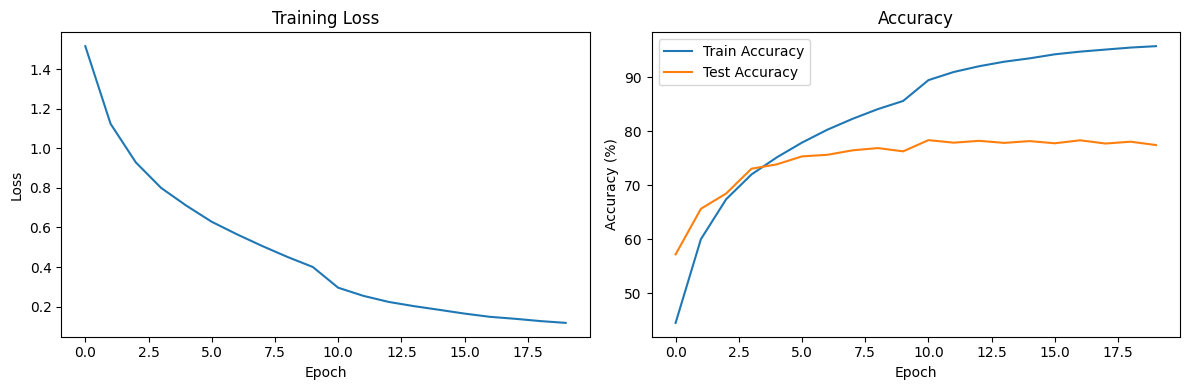

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()



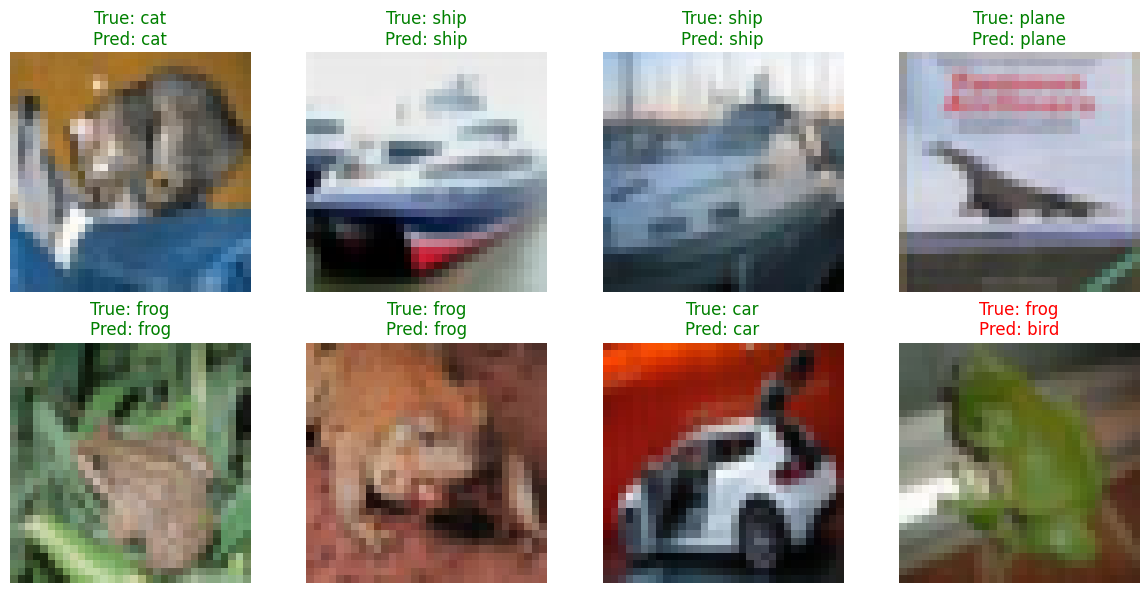

In [14]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = outputs.max(1)

fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    imshow(images[i].cpu())
    ax.set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', 
                 color='green' if labels[i] == predicted[i] else 'red')
plt.tight_layout()
plt.show()

